# Tarefa: Treinando uma árvore de decisão do dataset de frutas


Nesta tarefa, vocês devem treinar e avaliar uma árvore de decisão no dataset de frutas. Utilizem o Colab e scikit-learn como base. Além de treinar no conjunto de treino e testar no de teste, juntem os datasets para também avaliarem de forma mais criteriosa utilizando k-folds ou bootstraping.

# Carregando os dados

No código abaixo irei carregar as tabelas de dados utilizando a biblioteca pandas. A primeira tabela será usada como treinamento e a outra como teste.

In [ ]:
# Baixar os dados
!wget https://www.dropbox.com/s/lopzmgfal5tzuo4/FrutasTreino.csv
!wget https://www.dropbox.com/s/iiw0p3gkpyksphl/FrutasTeste.csv

import pandas as pd

dados_treino = pd.read_csv("FrutasTreino.csv", index_col=0)
dados_teste = pd.read_csv("FrutasTeste.csv", index_col=0)
dados_completos = pd.concat([dados_treino,dados_teste]) #Juntando ambas tabelas para depois avaliar usando k-folds e bootstraping

--2021-08-30 17:45:53--  https://www.dropbox.com/s/lopzmgfal5tzuo4/FrutasTreino.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lopzmgfal5tzuo4/FrutasTreino.csv [following]
--2021-08-30 17:45:53--  https://www.dropbox.com/s/raw/lopzmgfal5tzuo4/FrutasTreino.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbd4150b5f7d03bece06c9c8c0c.dl.dropboxusercontent.com/cd/0/inline/BVMrnCgGlypF3uqOUTndG-d7HdLRezAYx8jVaI7F38iDuKaqT6XWvlqztGguOre7AjY8Sw3-ksqpqQlbK8xcfsw8ZoSPfit0DN0OVNn2FOrnIIL2M_Xm5QRktrZ_Vpgat4SHYqob-xAvo6CpAXiXPtvf/file# [following]
--2021-08-30 17:45:54--  https://ucbd4150b5f7d03bece06c9c8c0c.dl.dropboxusercontent.com/cd/0/inline/BVMrnCgGlypF3uqOUTndG-d7HdLRezAYx8jVaI7F38iDuKaqT6XWvlqztGguOre7AjY8Sw3-ksqpq

# Treinamento

Para treinar vamos utilizar uma árvore de decisão como modelo. O sklearn implementa o `DecisionTreeClassifier`, que é um modelo CART. Podemos aproximar o modelo do C4.5 usando entropia no lugar de gini para decidir os atributos em cada nó.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier(random_state=0, criterion="entropy")

# A função fit recebe como primeiro parâmetro uma matriz CxN, com C colunas e N linhas, onde cada linha especifica um exemplo
# O segundo parâmetro é um vetor com N posições, indicando os rótulos das linhas da matriz no primeiro parâmetro

x_treino = dados_treino.drop('fruit_name', axis='columns')
y_treino = dados_treino['fruit_name']
modelo_treinado = modelo.fit(x_treino, y_treino)

# Avaliação do modelo

Com o modelo treinado, temos que avaliá-lo no conjunto de teste. O sklearn implementa a maior parte das métricas comuns, bem como permite mostrar a matriz de confusão completa. 

In [ ]:
from sklearn.metrics import accuracy_score

# Separamos atributos e classe dos dados de teste
x_teste = dados_teste.drop('fruit_name', axis='columns')
y_teste = dados_teste['fruit_name']

# Passamos os exemplos sem classe pelo modelo treinado, que retorna a predicao em um vetor
predicoes = modelo_treinado.predict(x_teste)

# Com as predicoes, podemos calcular as métricas. Abaixo, a acurácia.

acuracia = accuracy_score(y_teste, predicoes)
print("Acurácia do modelo: ", acuracia)


Acurácia do modelo:  0.9090909090909091


Apesar de termos obtido 90.9% de acurácia não podemos afirmar o quão bom foi nosso modelo, visto que as classes podem não são perfeitamente balanceadas, abaixo podemos plotar mais dados que permitam uma melhor interpretação dos resultados obtidos.

In [ ]:
from sklearn.metrics import classification_report

relatorio = classification_report(y_teste, predicoes)
print(relatorio)

              precision    recall  f1-score   support

       apple       1.00      0.75      0.86         4
       lemon       1.00      1.00      1.00         3
    mandarin       1.00      1.00      1.00         1
      orange       0.75      1.00      0.86         3

    accuracy                           0.91        11
   macro avg       0.94      0.94      0.93        11
weighted avg       0.93      0.91      0.91        11



Ao criar a matriz de confusão para os resultados podemos observar aonde nosso modelo está errando com mais clareza, podemos por exemplo observar que ele está classificando uma das maças como laranja, é bem efidente que com a matriz de confusão podemos perceber o quão bom está nosso modelo e aonde o mesmo está errando. Porém fica a pergunta se estamos de fato testando nosso modelo de forma eficiente, para isso podemos usar outras métricas de avaliação mais poderosas como k-folds e bootstraping.

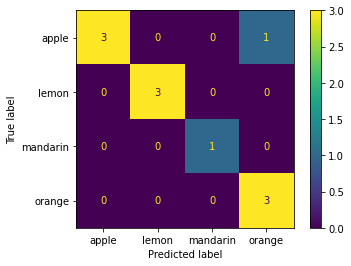

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(modelo_treinado, x_teste, y_teste)

##Melhorando a avaliação
Para melhorar a avaliação irei utilizar a tabela de dados completa, que vem a ser uma junção da tabela de treinamento com a de teste, nessa tabela contendo todos os dados irei aplicar duas técnicas de validação cruzada chamadas **bootstrapping** e **k-fold**.

## Bootstrapping

Uma primeira ideia é repetir o proceso todo várias vezes, criando uma separação aleatória a cada vez e treinando modelos independentes. Então, podemos pegar a média das métricas obtidas com cada modelo. Esta técnica de validação cruzada é chamada **bootstrapping**. Podemos usar a função `ShuffleSplit` do sklearn para isso.

In [ ]:
from sklearn.model_selection import ShuffleSplit

X = dados_completos.drop('fruit_name', axis='columns')
y = dados_completos['fruit_name']

# Vamos criar 10 separações, mantendo 20% de teste em cada uma
rs = ShuffleSplit(n_splits=10, test_size=.2)

# List para armazernamos as acurácias de cada modelo
acuracias = []

# Agora iteramos por cada separação e treinamos um modelo
# O método split retorna índices para o vetor passado como parametro
# O .loc é a maneira de indexar tabelas no pandas a partir de índices
for train_index, test_index in rs.split(X):
  modelo_treinado = modelo.fit(X.iloc[train_index], y.iloc[train_index])
  predicoes = modelo_treinado.predict(X.iloc[test_index])
  acuracias.append(accuracy_score(y.iloc[test_index], predicoes))

print(acuracias)
print("Média das acurácias: ", sum(acuracias) / len(acuracias))
#Uma abordagem seria estratificar a separação entre treino/teste. A estratificação procura garantir que a distribuição dos dados é semelhante entre os grupos. Ela pode ser feita tanto para atributos como para rótulos. 


[0.9166666666666666, 0.8333333333333334, 0.75, 1.0, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334]
Média das acurácias:  0.8833333333333334


Podemos observar que obtemos 88% de acurácia, bem próximo dos 90,9% que obtivemos no teste anterior. Vale observar que ao rodar novamente o teste poderemos obter um valor de acurácia diferente visto que as separações são feitas de forma aleatória.
Fica bem claro que esta acurácia estima melhor que a anterior pois foi um resultado de uma média de diversos testes. Podemos aumentar o número de execuções para termos uma estimativa melhor, porém nem sempre poderemos deviado ao tempo computacional que pode ser preciso em alguns casos.

## K-Fold

Uma alternativa a esta abordagem é denominada validação cruzada *k-fold* (k-partições? Não há uma boa tradução ainda.). A ideia é embaralhar os dados e então dividí-los em *k* partições. Então, separamos a primeira partição como teste e treinamos um modelo nas *k-1* partições restantes; na sequência, separamos a *segunda* partição como teste e treinamos outro modelo nas restantes e assim por diante até que todas partições tenham participado do teste. 

Com isso, treinamos *k* modelos sobre dados diferentes. Como antes, podemos pegar as médias de cada métrica para usarmos como estimativas.

O sklearn nos fornece uma função que automatiza o processo e não precisamos criar o loop manualmente como fizemos antes. Esta função é a `cross_val_score`.

In [ ]:
from sklearn.model_selection import cross_val_score

# O parâmetro cv indica quantas partições criaremos
scores = cross_val_score(modelo, X, y, cv=5)
print("Acurácia média: ", scores.mean())

Acurácia média:  0.8818181818181818


Da mesma forma que no bootstrapping, mais uma vez obtivemos uma acurácia próxima aos 88%, então me parece razoável dizer que esse modelo teve um desempenho bem superior ao que eu havia criado manualmente na tarefa anterior, na qual o modelo obteve uma acurácia de 73%. Apesar de não ter utilizado uma boa métrica de avaliação para o modelo que criei manualmente, acredito que podemos dizer que o modelo criado nessa tarefa foi bem mais eficiente que o modelo criado manualmente.